In [1]:
import pandas as pd 
import numpy as np
from numpy import linalg as la
from prettytable import PrettyTable
from PIL import Image, ImageDraw, ImageFont
import itertools


In [2]:
# folder creations 

!mkdir Plots
!mkdir Tables

# K-means Clustering

## Iris Dataset implementation

In [3]:
from sklearn.datasets import load_iris

In [4]:
from sklearn.cluster import KMeans

meas = load_iris().data 
X = meas[:, [2,3]] 
y = load_iris().target
k = 3 

kmeans = KMeans(n_clusters=k).fit(X)

IDX = kmeans.labels_
C = kmeans.cluster_centers_

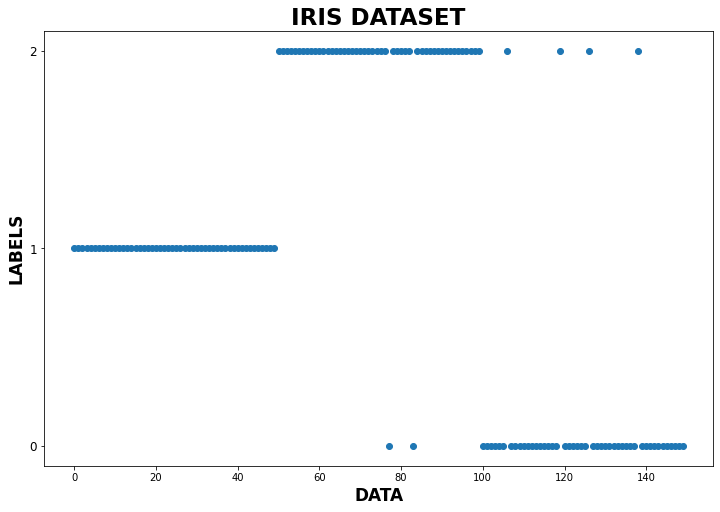

In [5]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,8)) # changing the size of the figure 

plt.plot(IDX[:], 'o')
plt.xlabel('DATA', fontsize=17, fontweight='bold') # naming the x axis 
plt.ylabel('LABELS', fontsize=17, fontweight='bold')
plt.title('IRIS DATASET', fontweight='bold', fontsize=23)
plt.yticks([0,1,2], fontsize=12) 
plt.savefig('Plots/scatter_iris_labels.png')
plt.show()

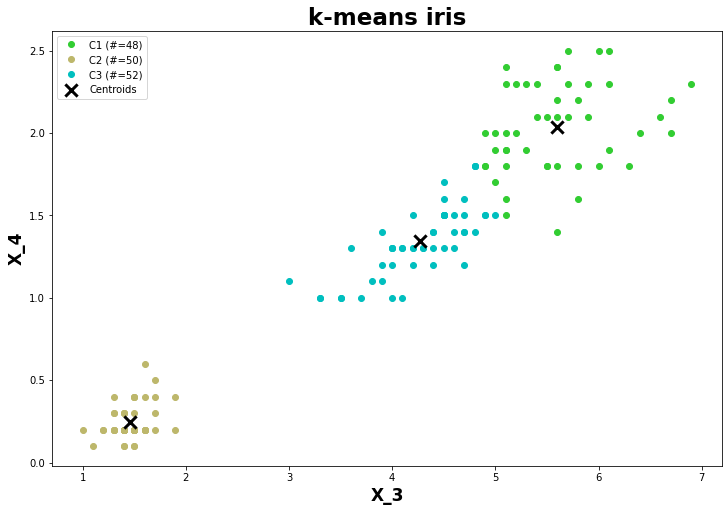

In [6]:
plt.rcParams['legend.fontsize'] = 10 # changing the size of the legend 

plt.figure(figsize=(12,8)) 
plt.plot(X[IDX==0][:, 0], X[IDX==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1 (#={})'.format(len(X[IDX==0])))
plt.plot(X[IDX==1][:, 0], X[IDX==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2 (#={})'.format(len(X[IDX==1])))
plt.plot(X[IDX==2][:, 0], X[IDX==2][:, 1], 'c.', marker='o', linewidth=0, label='C3 (#={})'.format(len(X[IDX==2])))

plt.xlabel('X_3', fontsize=17, fontweight='bold')
plt.ylabel('X_4', fontsize=17, fontweight='bold')
plt.scatter(C[:,0], C[:,1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)
plt.title('k-means iris', fontweight='bold', fontsize=23)
plt.legend()

plt.savefig('Plots/Iris_kmeans_cl3.png')
plt.show()

In [7]:
import prettytable
from sklearn.metrics import silhouette_score # importing the sihlouette metric

# creating a function to easily perform k-means on the iris dataset
def k_means_iris(X, k, init_='k-means++', n_init_=10 ):

  # performing k-means
  kmeans = KMeans(n_clusters=k, init=init_, n_init=n_init_).fit(X)

  # returning the centers
  return kmeans.cluster_centers_, kmeans.labels_, kmeans.n_iter_ 

# creating the SSE metric
def SSE(X, C, k):
  all_cluster_sse = [] # contains all cluster sse's
  for i in range(k):
    cluster_dists = [] # contains all distances between cluster center and cluster points
    for j in range(len(X)):
      dist = la.norm(C[i, :] - X[j, :]) # distance of cluster center i and cluster point j
      if dist == min( [la.norm(C[n, :] - X[j,:]) for n in range(k)] ): 
        cluster_dists.append(dist) # if point belongs to that cluster then add it in the cluster distances
    cluster_sse = sum( [d**2 for d in cluster_dists] ) # finding cluster sse 
    all_cluster_sse.append(cluster_sse) # adding the cluster sse to the list that contains all cluster sse's

  return sum(all_cluster_sse) # returning the total sse 

# performs k-means for different clusters (1,..., k_max)
def cluster_experiment(init_parameter, k_max=11, n_init__=10):
  k_range = [i for i in range(1, k_max)] # different values of k
  sse_list = [] # the sse for each k
  sil_list = [] # the silhouette score for each k
  n_iter_list = [] # contains the iterations the algorithm did to converge for every k
  centers = [] # this will contain all the centers for each k
  label_list = [] # will contain the labels that the k-means found 

  for k in k_range:
    C, labels, n_iter = k_means_iris(X, k, init_=init_parameter, n_init_ = n_init__) # saving Centers, labels and number of iterations until convergence

    label_list.append(labels) # adding the labels

    centers.append(C) # adding the centers for the current k 

    n_iter_list.append(n_iter) # adding the number of iteratins for the current k in the n_iter_list

    sse_list.append(SSE(X, C, k)) # adding the SSE for the current k in the sse_list

    if k != 1: # silhouette score cannot be computed for k = 1
      sil_list.append(silhouette_score(X, labels))

  # Specify the Column Names while initializing the Table
  results_table = PrettyTable(title='init = {}'.format(init_parameter), field_names=["Clusters", "SSE", "Silhouette Score", "Iterations"], float_format='.2')
  
  results_table.add_row([1, sse_list[0], 'NaN', n_iter_list[0]])
  for k in range(len(sil_list)):
    # adding rows to table
    results_table.add_row([k + 2, sse_list[k + 1], sil_list[k], n_iter_list[k]]) # adding rows to the table

  print(results_table)
  save_table(results_table,'cluster_table_{}'.format(init_parameter)) # saving the table 

  return k_range, sse_list, sil_list, n_iter_list, centers, label_list

# performs k-means for different dimensions
def dim_experiment(k, init_parameter, print_info=True):

  # creating new_X every time with different dimensions
  X_C1 = X[y==0] # X for class 1
  X_C2 = X[y==1] # X for class 2
  X_C3 = X[y==2] # X for class 3

  sse_list = [] # the sse for each variation of the dimetions of X
  sil_list = [] # the silhouette score for each dim of X
  n_iter_list = [] # contains the iterations the algorithm did to converge for every dim of X
  Xdim_strings = [] # contains the strings of the type 150 x 2

  for i in range(2,51): # start from 2 because if there is only one point in each cluster then the silhouette score cannot be computed
    
    # removing data from each class 
    new_X_C1 = X_C1[0:i, :] 
    new_X_C2 = X_C2[0:i, :]
    new_X_C3 = X_C3[0:i, :]

    # creating the new X with lower dimension
    new_X = np.concatenate((new_X_C1, new_X_C2, new_X_C3), axis=0)
    Xdim_string = str(new_X.shape[0]) + ' x ' + str(new_X.shape[1]) # the X dim string of the current X dim 

    C, labels, n_iter = k_means_iris(new_X, k, init_=init_parameter)
    n_iter_list.append(n_iter) # adding the number of iterations for the current dim of X in the n_iter_list
    sse_list.append(SSE(new_X, C, k)) # adding the SSE for the current dim of X in the sse_list
    sil_list.append(silhouette_score(new_X, labels)) # adding silhouette score for the current dim of X
    Xdim_strings.append(Xdim_string)
  
  if print_info == True:
    
    results_table = PrettyTable(title='clusters = {}   init = {}'.format(k, init_parameter), \
                                field_names=['Dim(X)', 'SSE', 'Silhouette Score', 'Iterations'], float_format='.2') # defining columns of the table
    
    for i in range(49):  
      # adding rows to the table
      results_table.add_row([Xdim_strings[i], sse_list[i], sil_list[i], n_iter_list[i]])

    print(results_table)
    save_table(results_table,'dim_table_{}_k{}'.format(init_parameter, k)) # saving the table 

    
  return sil_list, Xdim_strings

# this function saves the table as a png image
def save_table(table, name):
  # Get the string representation of the table
  table_str = table.get_string()

  # Setting the default font 
  font = ImageFont.load_default()

  # Calculate the size of the image based on the size of the text
  text_width, text_height = ImageDraw.Draw(Image.new('RGB', (1, 1))).textsize(table_str, font=font)
  image_width = text_width + 20
  image_height = text_height + 20

  # Create the image and draw the text on it
  image = Image.new('RGB', (image_width, image_height), (255, 255, 255))
  draw = ImageDraw.Draw(image)
  draw.text((10, 10), table_str, font=font, fill=(0, 0, 0))

  # Save the image to a file
  image.save('Tables/{}.png'.format(name))

# this function normalizes the 2-Dimensional data for each axis in a way 
# such that the distances of the data are preserved 
# Formula := X_i = a + (X_i - Xmin)(b-a) / (Xmax - Xmin)
def normalize(X):

  y_axDist = max(X[:, 1]) - min(X[:, 1]) # the maximum distance of the data on y-axis
  x_axDist = max(X[:, 0]) - min(X[:, 0]) # the maximum distance of the data on x-axis
  r = min( x_axDist / y_axDist, y_axDist / x_axDist ) # the ration of the distances such that r < 1 

  # both starting points will be starting from 0
  a_x = 0
  a_y = 0
  # the axis with the smaller data distance will have the corresponding set [0, r]
  if y_axDist < x_axDist: 
    # defining ending point of the set of y and x
    b_y = r 
    b_x = 1
  else:
    b_y = 1
    b_x = r
    
  # normalizing the axes
  col1 = a_x + (X[:,0] - min(X[:,0]))*(b_x - a_x) / (max(X[:,0]) - min(X[:,0]))
  col2 = a_y + (X[:,1] - min(X[:,1]))*(b_y - a_y) / (max(X[:,1]) - min(X[:,1]))

  X = np.array([[x, y] for x, y in zip(col1, col2)])

  return X


#### Experiments where $k \in \{2,3,...,10 \}$ and init = 'k-means++'

In [8]:
# trying different clusters, using the k-means++ init parameter
k_range, sse_list, sil_list, n_iter_list, centers, label_list = cluster_experiment('k-means++')

+---------------------------------------------------+
|                  init = k-means++                 |
+----------+--------+------------------+------------+
| Clusters |  SSE   | Silhouette Score | Iterations |
+----------+--------+------------------+------------+
|    1     | 550.90 |       NaN        |     2      |
|    2     | 86.39  |       0.77       |     2      |
|    3     | 31.37  |       0.66       |     3      |
|    4     | 19.48  |       0.61       |     7      |
|    5     | 13.92  |       0.59       |     6      |
|    6     | 11.08  |       0.58       |     6      |
|    7     |  9.25  |       0.58       |     7      |
|    8     |  7.71  |       0.59       |     5      |
|    9     |  6.58  |       0.59       |     3      |
|    10    |  5.53  |       0.43       |     6      |
+----------+--------+------------------+------------+


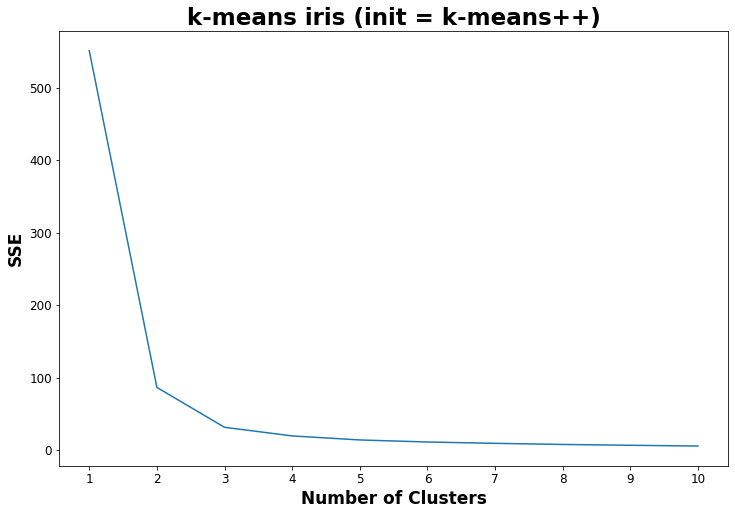

In [9]:
plt.figure(figsize=(12,8)) # making the figure bigger


plt.xticks([i for i in range(11)], fontsize=12) # adding x-ticks with bigger fontsize
plt.xlabel('Number of Clusters', fontsize=17, fontweight='bold') # adding label for x-axis

plt.ylabel('SSE', fontsize=17, fontweight='bold') # adding label for y-axis 
plt.yticks([i for i in range(0,600,100)], fontsize=12) # adding y ticks with bigger fontsize
plt.title('k-means iris (init = k-means++)', fontsize=23, fontweight='bold') # adding title 
plt.plot(k_range, sse_list) # plotting the data
plt.savefig('Plots/sse_iris_kmeanspp.png')
plt.show() # showing the figure 

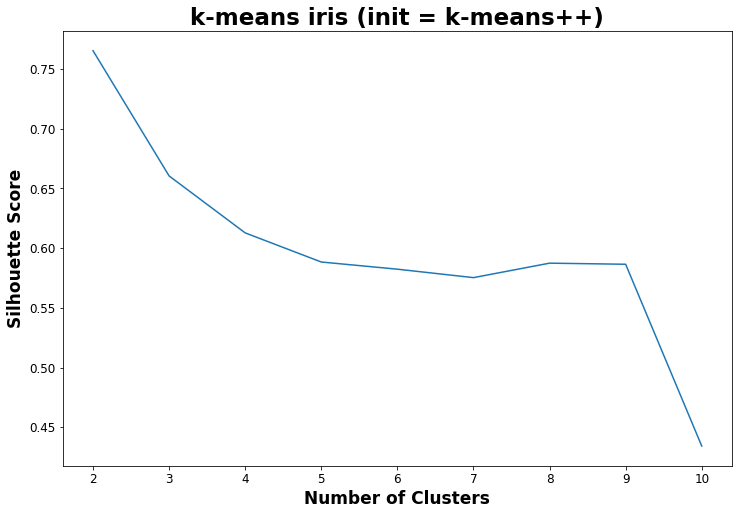

In [10]:
plt.figure(figsize=(12,8)) # making the figure bigger

plt.xticks([i for i in range(11)], fontsize=12) # adding x-ticks with bigger fontsize
plt.xlabel('Number of Clusters', fontsize=17, fontweight='bold') # adding label for x-axis

plt.ylabel('Silhouette Score', fontsize=17, fontweight='bold') # adding label for y-axis 
plt.yticks( fontsize=12) # adding y ticks with bigger fontsize
plt.title('k-means iris (init = k-means++)', fontsize=23, fontweight='bold') # adding title 
plt.plot(k_range[1::], sil_list) # plotting the data
plt.savefig('Plots/sil_iris_kmeanspp.png')
plt.show() # showing the figure 

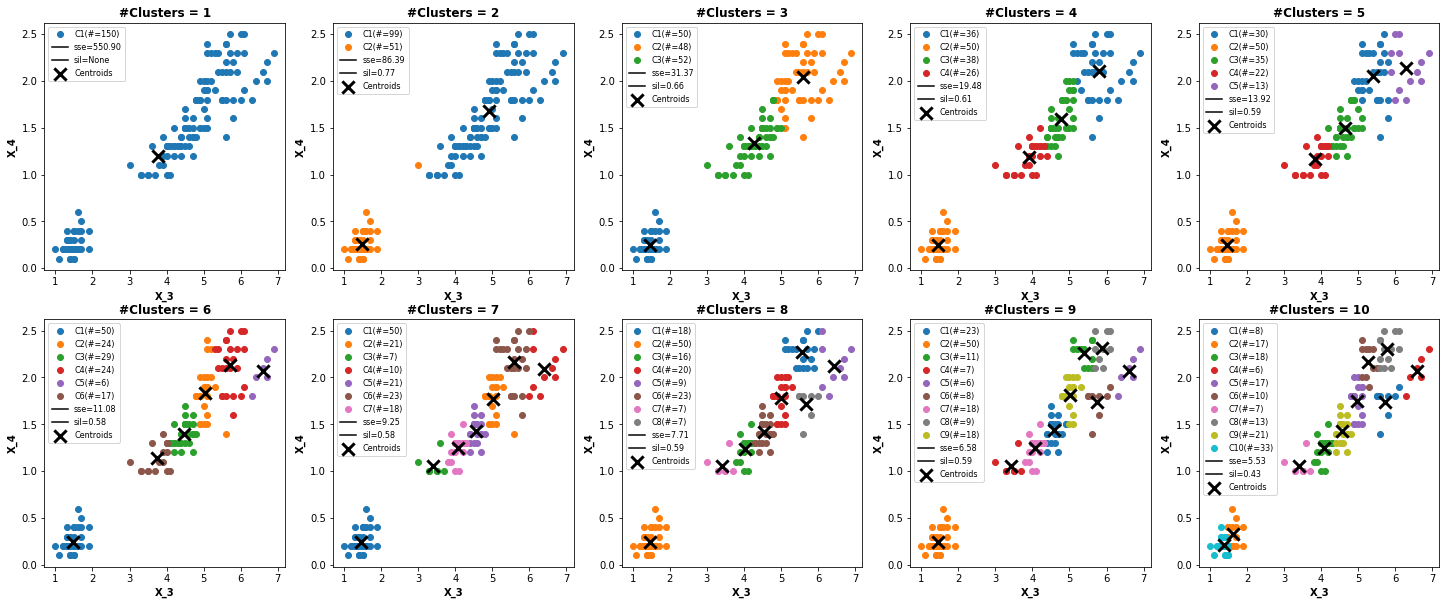

In [11]:
plt.rcParams['legend.fontsize'] = 8

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(25,10)) # creating 10 ax objects to draw graphs
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 ,ax10] # putting all the axes in a list
for i in range(len(ax)):

  IDX = label_list[i] # the clustering for this iteration 
  labels = list(set(IDX)) # the classes
  if i + 1>= 2: 
    sil = silhouette_score(X, IDX) # calculating the sihlouette score 
  else:
    sil='None'
  
  sse = sse_list[i] # calculating the sse
  for k in labels:
    ax[i].plot(X[IDX==k][:, 0], X[IDX==k][:, 1],  marker='o', linewidth=0, label='C'+str(k + 1) +'(#={})'.format(len(X[IDX==k])) )  # drawing the Class j

  ax[i].set_xlabel('X_3', fontsize=10, fontweight='bold') # setting the label bold and size 10
  ax[i].set_ylabel('X_4', fontsize=10, fontweight='bold') # setting the label bold, size 10 and rotating it so it is easy to read

  ax[i].scatter(centers[i][:, 0], centers[i][:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10) # scatter plot the centers
  
  ax[i].set_title('#Clusters = {}'.format(i+1), fontweight='bold') # adding title 
  ax[i].plot([],[], label='sse={:.2f}'.format(sse), c='k')
  if i + 1>= 2:
    ax[i].plot([],[], label='sil={:.2f}'.format(sil), c='k')
  else:
    ax[i].plot([],[], label='sil={}'.format(sil), c='k')


  ax[i].legend(loc='upper left') # adding labels

plt.savefig('Plots/cluster_exp_kmeanspp.png')
plt.show()

#### Experiments where $k \in \{2,3,...,10\}$ and init = 'random'


In [12]:
# trying different clusters, using the k-means++ init parameter
k_range, sse_list, sil_list, n_iter_list, centers, label_list = cluster_experiment('random')

+---------------------------------------------------+
|                   init = random                   |
+----------+--------+------------------+------------+
| Clusters |  SSE   | Silhouette Score | Iterations |
+----------+--------+------------------+------------+
|    1     | 550.90 |       NaN        |     2      |
|    2     | 86.39  |       0.77       |     2      |
|    3     | 31.37  |       0.66       |     6      |
|    4     | 19.48  |       0.61       |     13     |
|    5     | 13.98  |       0.59       |     12     |
|    6     | 11.07  |       0.58       |     13     |
|    7     |  9.46  |       0.59       |     4      |
|    8     |  8.05  |       0.57       |     5      |
|    9     |  6.80  |       0.43       |     4      |
|    10    |  5.59  |       0.43       |     8      |
+----------+--------+------------------+------------+


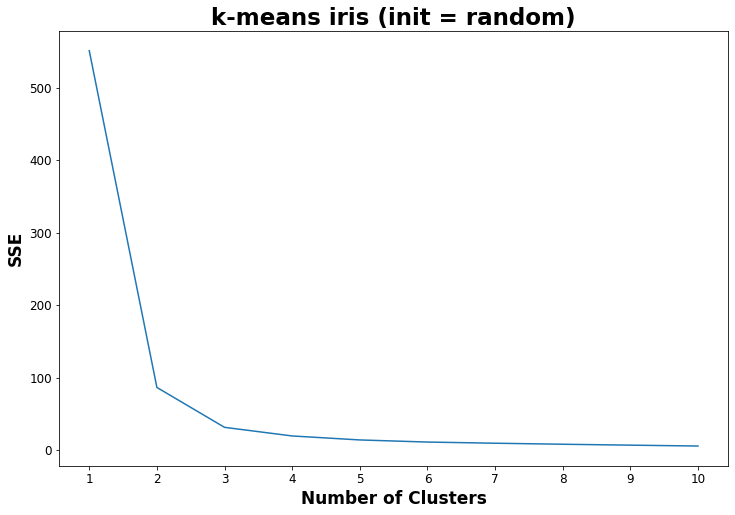

In [13]:
plt.figure(figsize=(12,8)) # making the figure bigger

plt.xticks([i for i in range(11)], fontsize=12) # adding xticks  with bigger fontsize
plt.xlabel('Number of Clusters', fontsize=17, fontweight='bold') # adding a x-axis label
plt.ylabel('SSE', fontsize=17, fontweight='bold') # adding a y-axis label

plt.yticks([i for i in range(0,600,100)], fontsize=12) # making the y ticks bigger
plt.title('k-means iris (init = random)', fontsize=23, fontweight='bold') # adding title
plt.plot(k_range, sse_list) # plotting the data

plt.savefig('Plots/sse_iris_random.png')
plt.show() # showing the plot 

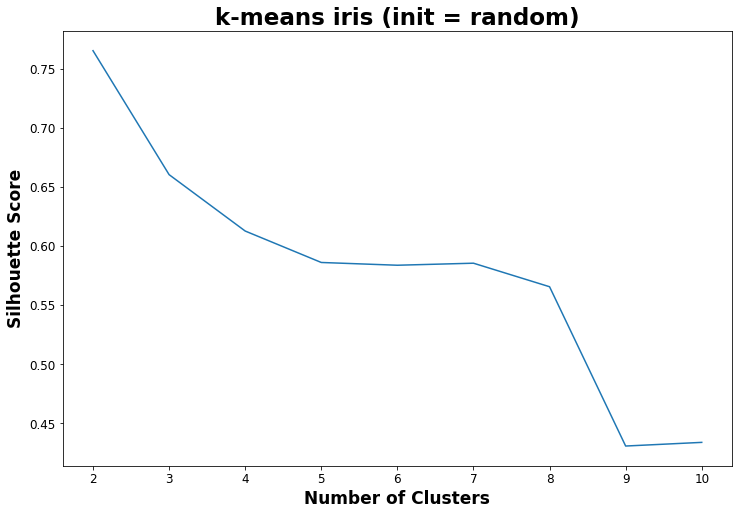

In [14]:
plt.figure(figsize=(12,8)) # making the figure bigger

plt.xticks([i for i in range(11)], fontsize=12) # adding x-ticks with bigger fontsize
plt.xlabel('Number of Clusters', fontsize=17, fontweight='bold') # adding label for x-axis

plt.ylabel('Silhouette Score', fontsize=17, fontweight='bold') # adding label for y-axis 
plt.yticks( fontsize=12) # adding y ticks with bigger fontsize
plt.title('k-means iris (init = random)', fontsize=23, fontweight='bold') # adding title 
plt.plot(k_range[1::], sil_list) # plotting the data
plt.savefig('Plots/sil_iris_random.png')
plt.show() # showing the figure 

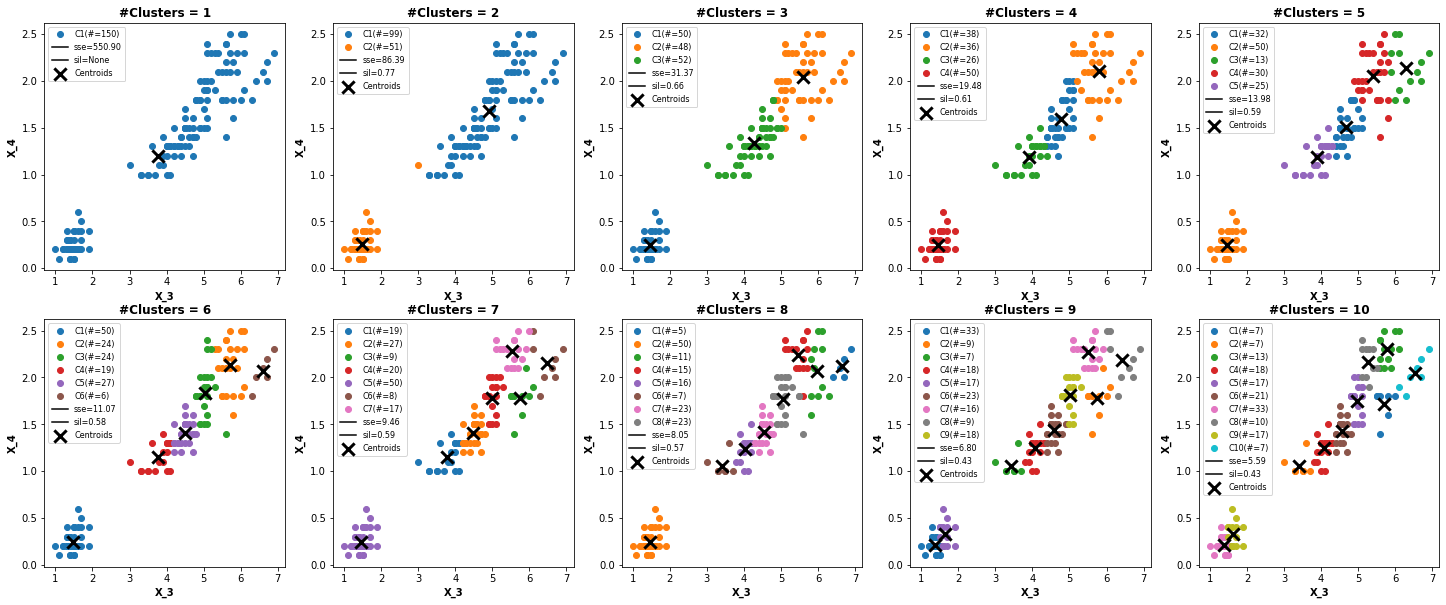

In [15]:
plt.rcParams['legend.fontsize'] = 8 # changing the size of the legend 

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(25,10)) # creating 10 ax objects to draw graphs
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 ,ax10] # putting all the axes in a list
for i in range(len(ax)):

  IDX = label_list[i] # the clustering for this iteration 
  labels = list(set(IDX)) # the classes
  if i + 1 >= 2: 
    sil = sil_list[i-1] # calculating the sihlouette score 
  else:
    sil='None'
  
  sse = sse_list[i] # calculating the sse
  for k in labels:
    ax[i].plot(X[IDX==k][:, 0], X[IDX==k][:, 1],  marker='o', linewidth=0, label='C'+str(k + 1) +'(#={})'.format(len(X[IDX==k])) )  # drawing the Class j

  ax[i].set_xlabel('X_3', fontsize=10, fontweight='bold') # setting the label bold and size 10
  ax[i].set_ylabel('X_4', fontsize=10, fontweight='bold') # setting the label bold, size 10 and rotating it so it is easy to read

  ax[i].scatter(centers[i][:, 0], centers[i][:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10) # scatter plot the centers
  
  ax[i].set_title('#Clusters = {}'.format(i+1), fontweight='bold') # adding title 
  ax[i].plot([],[], label='sse={:.2f}'.format(sse), c='k')
  if i + 1>= 2:
    ax[i].plot([],[], label='sil={:.2f}'.format(sil), c='k')
  else:
    ax[i].plot([],[], label='sil={}'.format(sil), c='k')


  ax[i].legend(loc='upper left') # adding labels

plt.savefig('Plots/cluster_exp_random.png')
plt.show()

#### Experiments where $k \in \{2, 3\} $ and $dim(X) \in \{1 \times 2, 2 \times 2,...,150 \times 2 \}$

##### $ k = 2  $,  $\ \ dim(X) \in \{6 \times 2, 9 \times 2,...,3n \times 2 ,...,150 \times 2 \}$ where $n \in \{1,2,...,50\}$, init = 'k-means++'

In [16]:
sil_list, Xdim_strings = dim_experiment(k=2, init_parameter='k-means++')

+-------------------------------------------------+
|         clusters = 2   init = k-means++         |
+---------+-------+------------------+------------+
|  Dim(X) |  SSE  | Silhouette Score | Iterations |
+---------+-------+------------------+------------+
|  6 x 2  |  2.08 |       0.83       |     2      |
|  9 x 2  |  2.90 |       0.84       |     2      |
|  12 x 2 |  4.65 |       0.82       |     2      |
|  15 x 2 |  5.65 |       0.83       |     2      |
|  18 x 2 |  8.61 |       0.81       |     2      |
|  21 x 2 |  9.25 |       0.82       |     2      |
|  24 x 2 | 14.16 |       0.75       |     3      |
|  27 x 2 | 15.15 |       0.76       |     2      |
|  30 x 2 | 18.38 |       0.75       |     2      |
|  33 x 2 | 21.48 |       0.76       |     2      |
|  36 x 2 | 22.30 |       0.76       |     2      |
|  39 x 2 | 24.18 |       0.76       |     2      |
|  42 x 2 | 24.56 |       0.77       |     3      |
|  45 x 2 | 27.08 |       0.76       |     2      |
|  48 x 2 | 

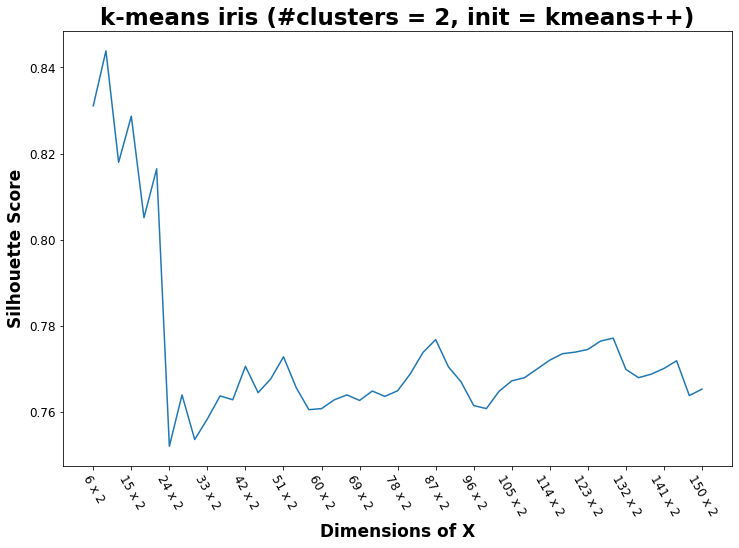

In [17]:

plt.figure(figsize=(12,8)) # changing the size of the figure

plt.title('k-means iris (#clusters = 2, init = kmeans++)', fontsize=23, fontweight='bold') # adding title with fontsize = 20
plt.xticks(range(0,len(Xdim_strings), 3), [dim for dim in Xdim_strings[::3]], rotation=-60, fontsize=12) # adding the dimensions of X as x ticks
plt.ylabel('Silhouette Score', fontsize=17, fontweight='bold')
plt.yticks(fontsize=12) # making y ticks fontsize bigger
plt.xlabel('Dimensions of X', fontsize=17, fontweight='bold') # adding label for x-axis
plt.plot([i for i in range(49)], sil_list) # plotting the data
plt.savefig('Plots/Sil_score_iris_k2_kmeanspp.png')
plt.show() # showing the figure

##### $ k = 3  $,  $\ \ dim(X) \in \{6 \times 2, 9 \times 2,...,3n \times 2 ,...,150 \times 2 \}$ where $n \in \{1,2,...,50\}$, init = 'k-means++'

Since the silhouette score cannot be computed with only one datapoint in each cluster , we will have dim(X) \in $\{6\times2, ... , 150\times2\}$

In [18]:
sil_list, Xdim_strings = dim_experiment(k=3, init_parameter='k-means++')

+-------------------------------------------------+
|         clusters = 3   init = k-means++         |
+---------+-------+------------------+------------+
|  Dim(X) |  SSE  | Silhouette Score | Iterations |
+---------+-------+------------------+------------+
|  6 x 2  |  0.33 |       0.64       |     2      |
|  9 x 2  |  0.44 |       0.77       |     2      |
|  12 x 2 |  1.27 |       0.67       |     2      |
|  15 x 2 |  1.28 |       0.73       |     2      |
|  18 x 2 |  1.93 |       0.74       |     3      |
|  21 x 2 |  2.00 |       0.76       |     2      |
|  24 x 2 |  3.98 |       0.72       |     2      |
|  27 x 2 |  4.14 |       0.73       |     2      |
|  30 x 2 |  4.67 |       0.74       |     2      |
|  33 x 2 |  6.22 |       0.70       |     3      |
|  36 x 2 |  6.54 |       0.70       |     2      |
|  39 x 2 |  6.86 |       0.71       |     2      |
|  42 x 2 |  7.69 |       0.69       |     3      |
|  45 x 2 |  8.66 |       0.68       |     4      |
|  48 x 2 | 

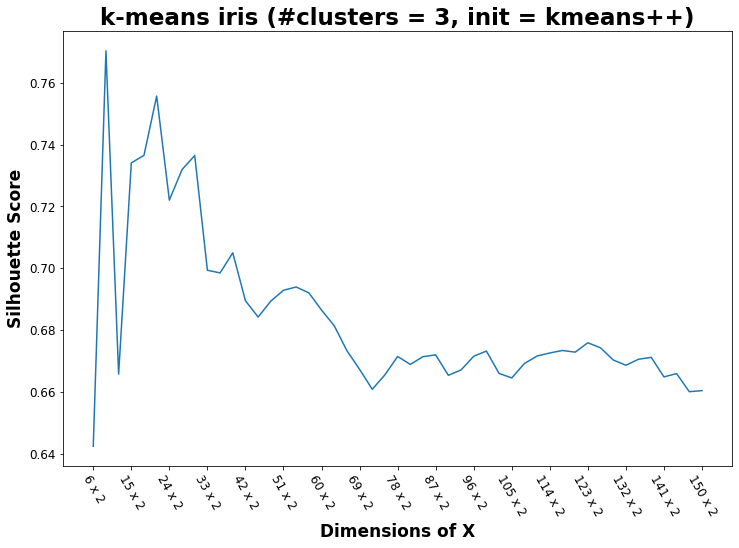

In [19]:
plt.figure(figsize=(12,8)) # changing the size of the figure

plt.title('k-means iris (#clusters = 3, init = kmeans++)', fontsize=23, fontweight='bold') # adding title with fontsize = 20
plt.xticks(range(0,len(Xdim_strings), 3), [dim for dim in Xdim_strings[::3]], rotation=-60, fontsize=12) # adding the dimensions as ticks in x-axis
plt.yticks(fontsize=12) # making y ticks bigger
plt.ylabel('Silhouette Score', fontsize=17, fontweight='bold')
plt.xlabel('Dimensions of X', fontsize=17, fontweight='bold') # adding label in x-axis
plt.plot([i for i in range(49)], sil_list) # plootting the silhouette score with respect to the dimensions of X
plt.savefig('Plots/Sil_score_iris_k3_kmeanspp.png')
plt.show() # showing the figure

##### $ k = 2  $,  $\ \ dim(X) \in \{6 \times 2, 9 \times 2,...,3n \times 2 ,...,150 \times 2 \}$ where $n \in \{1,2,...,50\}$, init = 'random'

In [20]:
sil_list, Xdim_strings = dim_experiment(k=2, init_parameter='random')

+-------------------------------------------------+
|           clusters = 2   init = random          |
+---------+-------+------------------+------------+
|  Dim(X) |  SSE  | Silhouette Score | Iterations |
+---------+-------+------------------+------------+
|  6 x 2  |  2.08 |       0.83       |     2      |
|  9 x 2  |  2.90 |       0.84       |     4      |
|  12 x 2 |  4.65 |       0.82       |     2      |
|  15 x 2 |  5.65 |       0.83       |     2      |
|  18 x 2 |  8.61 |       0.81       |     4      |
|  21 x 2 |  9.25 |       0.82       |     5      |
|  24 x 2 | 14.16 |       0.75       |     4      |
|  27 x 2 | 15.15 |       0.76       |     4      |
|  30 x 2 | 18.38 |       0.75       |     3      |
|  33 x 2 | 21.48 |       0.76       |     2      |
|  36 x 2 | 22.30 |       0.76       |     2      |
|  39 x 2 | 24.18 |       0.76       |     2      |
|  42 x 2 | 24.56 |       0.77       |     2      |
|  45 x 2 | 27.08 |       0.76       |     3      |
|  48 x 2 | 

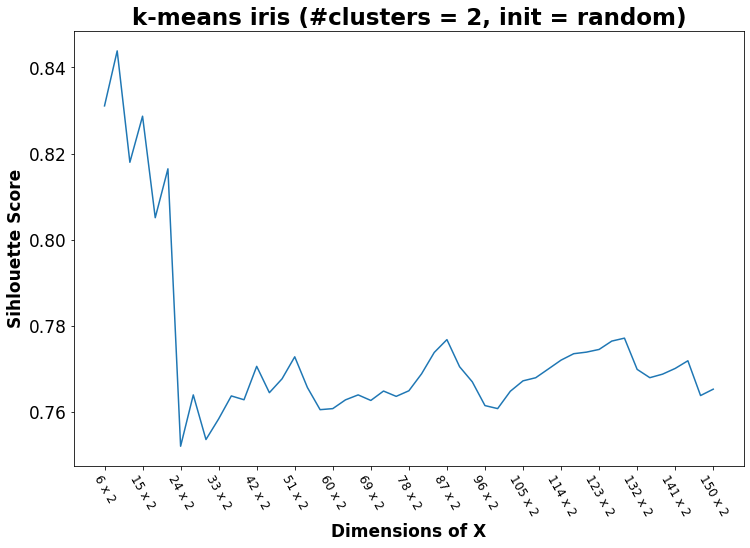

In [21]:
plt.figure(figsize=(12,8)) # changing the size of the figure

plt.title('k-means iris (#clusters = 2, init = random)', fontsize=23, fontweight='bold') # adding title with fontsize = 20
plt.xticks(range(0,len(Xdim_strings), 3), [dim for dim in Xdim_strings[::3]], rotation=-60, fontsize=12) # adding the dimensions as ticks in x-axis
plt.yticks(fontsize=17) # making y ticks bigger
plt.xlabel('Dimensions of X', fontsize=17, fontweight='bold') # adding label in x-axis
plt.ylabel('Sihlouette Score', fontsize=17 , fontweight='bold')
plt.plot([i for i in range(49)], sil_list) # plootting the silhouette score with respect to the dimensions of X
plt.savefig('Plots/Sil_score_iris_k2_random.png')
plt.show() # showing the figure

##### $ k = 3  $,  $\ \ dim(X) \in \{6 \times 2, 9 \times 2,...,3n \times 2 ,...,150 \times 2 \}$ where $n \in \{1,2,...,50\}$, init = 'random'

In [22]:
sil_list, Xdim_strings = dim_experiment(k=3, init_parameter='random')

+-------------------------------------------------+
|           clusters = 3   init = random          |
+---------+-------+------------------+------------+
|  Dim(X) |  SSE  | Silhouette Score | Iterations |
+---------+-------+------------------+------------+
|  6 x 2  |  0.33 |       0.64       |     3      |
|  9 x 2  |  0.44 |       0.77       |     2      |
|  12 x 2 |  1.27 |       0.67       |     3      |
|  15 x 2 |  1.28 |       0.73       |     3      |
|  18 x 2 |  1.93 |       0.74       |     2      |
|  21 x 2 |  2.00 |       0.76       |     2      |
|  24 x 2 |  3.98 |       0.72       |     2      |
|  27 x 2 |  4.14 |       0.73       |     2      |
|  30 x 2 |  4.67 |       0.74       |     4      |
|  33 x 2 |  6.22 |       0.70       |     5      |
|  36 x 2 |  6.54 |       0.70       |     7      |
|  39 x 2 |  6.86 |       0.71       |     4      |
|  42 x 2 |  7.69 |       0.69       |     4      |
|  45 x 2 |  8.66 |       0.68       |     5      |
|  48 x 2 | 

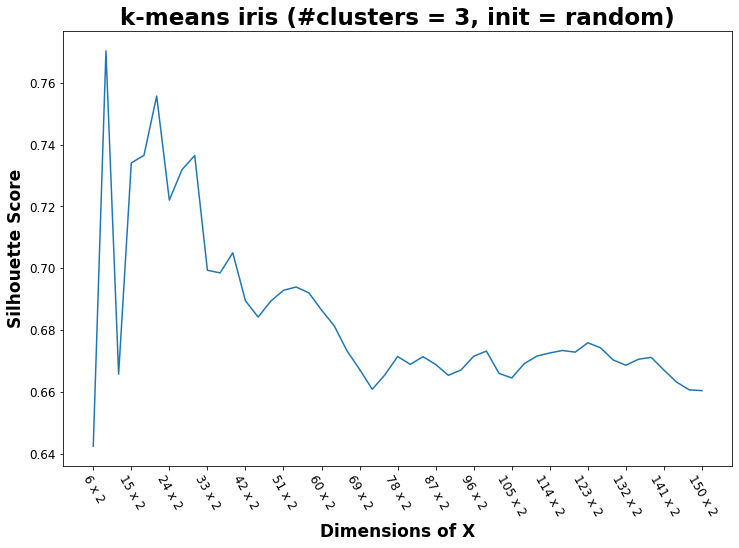

In [23]:
plt.figure(figsize=(12,8)) # changing the size of the figure

plt.title('k-means iris (#clusters = 3, init = random)', fontsize=23, fontweight='bold') # adding title with fontsize = 20
plt.xticks(range(0,len(Xdim_strings), 3), [dim for dim in Xdim_strings[::3]], rotation=-60, fontsize=12) # adding the dimensions as ticks in x-axis
plt.yticks(fontsize=12) # making y ticks bigger
plt.xlabel('Dimensions of X', fontsize=17, fontweight='bold') # adding label in x-axis
plt.ylabel('Silhouette Score', fontsize=17, fontweight='bold')
plt.plot([i for i in range(49)], sil_list) # plootting the silhouette score with respect to the dimensions of X
plt.savefig('Plots/Sil_score_iris_k3_random.png')
plt.show() # showing the figure

## xV.mat Dataset

In [24]:
import scipy.io
import numpy as np 

mat_file = scipy.io.loadmat('xV.mat')
xV = np.array(mat_file['xV'])

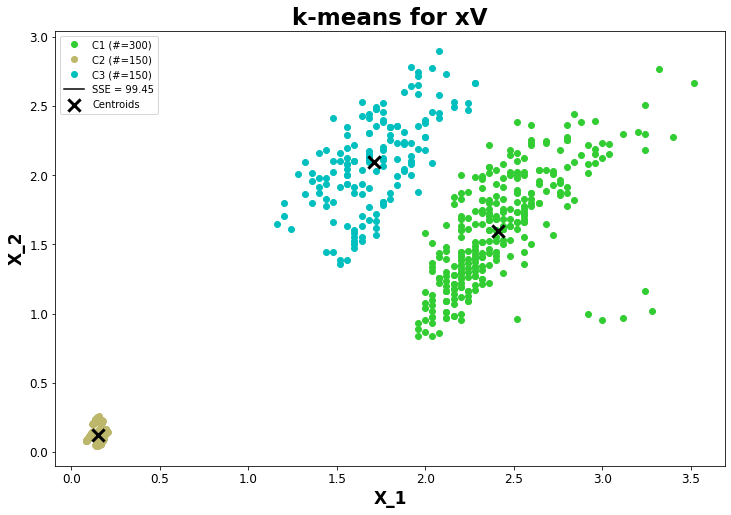

In [25]:
plt.rcParams['legend.fontsize'] = 10 # changing the size of the legend 


X_2 = xV[:, [0,1]]
k = 3 
kmeans = KMeans(n_clusters=k).fit(X_2)
IDX_2 = kmeans.labels_
C_2 = kmeans.cluster_centers_

plt.figure(figsize=(12,8))
plt.xlabel('X_1', fontweight='bold', fontsize=17) # changing fontweight and size
plt.ylabel('X_2', fontweight='bold', fontsize=17)
plt.title('k-means for xV', fontsize=23, fontweight='bold')

plt.xticks(fontsize=12) # changing fontsize of x and y ticks
plt.yticks(fontsize=12)

plt.plot(X_2[IDX_2==0][:, 0], X_2[IDX_2==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1 (#={})'.format(len(X_2[IDX_2==0])))
plt.plot(X_2[IDX_2==1][:, 0], X_2[IDX_2==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2 (#={})'.format(len(X_2[IDX_2==1])))
plt.plot(X_2[IDX_2==2][:, 0], X_2[IDX_2==2][:, 1], 'c.', marker='o', linewidth=0, label='C3 (#={})'.format(len(X_2[IDX_2==2])))

plt.scatter(C_2[:, 0], C_2[:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)

# Computing the SSE 
sse_2 = SSE(X_2, C_2, k)

# adding the SSE to the plot 
plt.plot([], [], label='SSE = {:.2f}'.format(sse_2), color='black')

plt.savefig('Plots/kmeans_xV_12.png')

plt.legend()
plt.savefig('Plots/kmeans_xV_12.png')

plt.show()

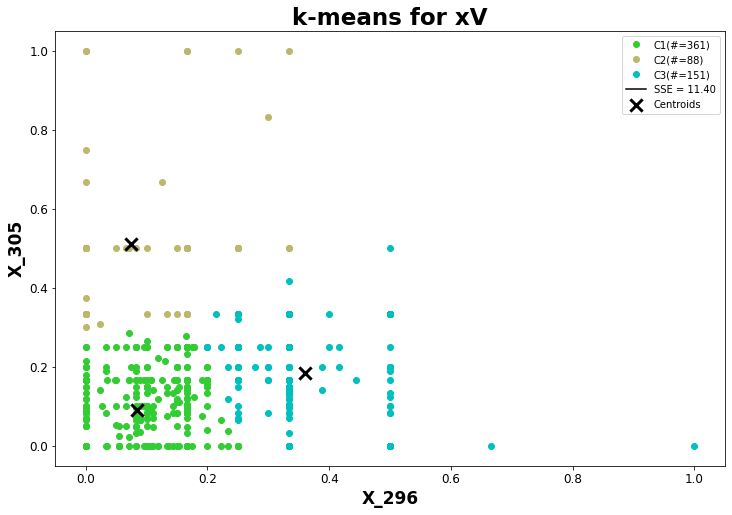

In [26]:
X = xV[:, [296,305]]
k = 3 
kmeans = KMeans(n_clusters=k).fit(X)
IDX = kmeans.labels_
C = kmeans.cluster_centers_

plt.figure(figsize=(12,8))
plt.xlabel('X_296', fontweight='bold', fontsize=17) # changing fontweight and size
plt.ylabel('X_305', fontweight='bold', fontsize=17)
plt.title('k-means for xV', fontsize=23, fontweight='bold')

plt.xticks(fontsize=12) # changing fontsize of x and y ticks
plt.yticks(fontsize=12)

plt.plot(X[IDX==0][:, 0], X[IDX==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1(#={})'.format(len(X[IDX==0])))
plt.plot(X[IDX==1][:, 0], X[IDX==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2(#={})'.format(len(X[IDX==1])))
plt.plot(X[IDX==2][:, 0], X[IDX==2][:, 1], 'c.', marker='o', linewidth=0, label='C3(#={})'.format(len(X[IDX==2])))

plt.scatter(C[:, 0], C[:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)

# Computing the SSE 
sse = SSE(X, C, k)
# adding the SSE to the plot 
plt.plot([], [], label='SSE = {:.2f}'.format(sse), color='black')

plt.legend()
plt.savefig('Plots/kmeans_xV_296305.png')

plt.show()

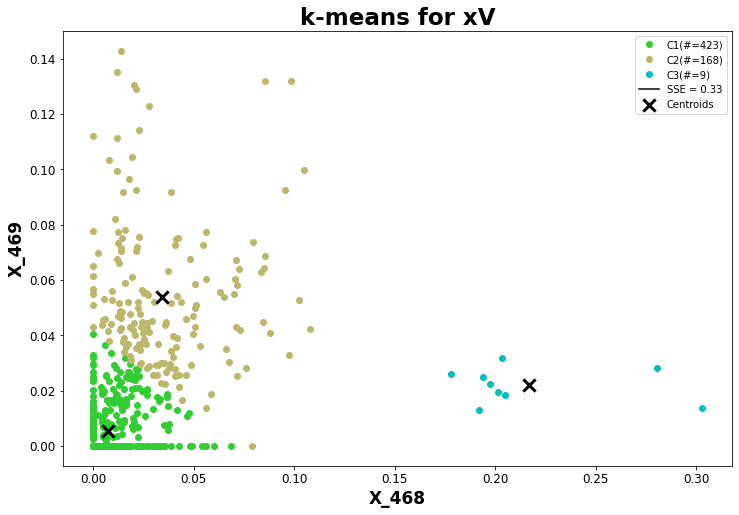

In [27]:
X_4 = xV[:, [-2,-1]]
k = 3 
kmeans = KMeans(n_clusters=k).fit(X_4)
IDX_4 = kmeans.labels_
C_4 = kmeans.cluster_centers_

plt.figure(figsize=(12,8))
plt.xlabel('X_468', fontweight='bold', fontsize=17) # changing fontweight and size
plt.ylabel('X_469', fontweight='bold', fontsize=17)
plt.title('k-means for xV', fontsize=23, fontweight='bold')

plt.xticks(fontsize=12) # changing fontsize of x and y ticks
plt.yticks(fontsize=12)

plt.plot(X_4[IDX_4==0][:, 0], X_4[IDX_4==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1(#={})'.format(len(X_4[IDX_4==0])))
plt.plot(X_4[IDX_4==1][:, 0], X_4[IDX_4==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2(#={})'.format(len(X_4[IDX_4==1])))
plt.plot(X_4[IDX_4==2][:, 0], X_4[IDX_4==2][:, 1], 'c.', marker='o', linewidth=0, label='C3(#={})'.format(len(X_4[IDX_4==2])))

plt.scatter(C_4[:, 0], C_4[:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)

# Computing the SSE 
sse_4 = SSE(X_4, C_4, k)
# adding the SSE to the plot 
plt.plot([], [], label='SSE = {:.2f}'.format(sse_4), color='black')

plt.legend()
plt.savefig('Plots/kmeans_xV_468469.png')

plt.show()

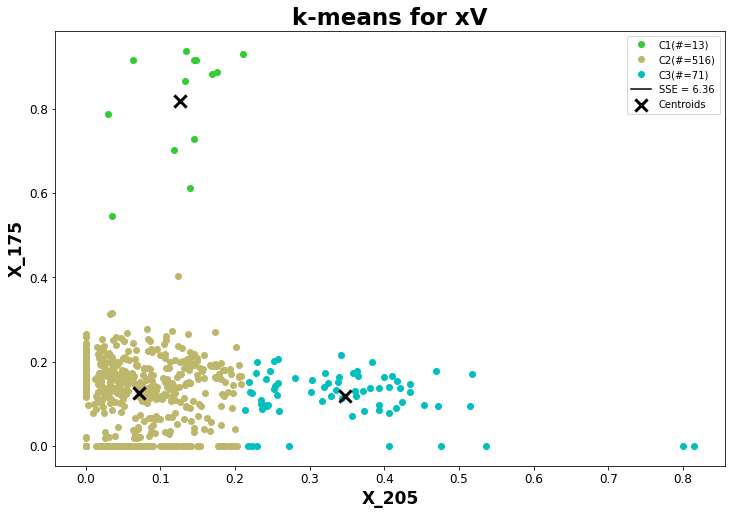

In [28]:
X_5 = xV[:, [205,175]]
k = 3 
kmeans = KMeans(n_clusters=k).fit(X_5)
IDX_5 = kmeans.labels_
C_5 = kmeans.cluster_centers_

plt.figure(figsize=(12,8))
plt.xlabel('X_205', fontweight='bold', fontsize=17) # changing fontweight and size
plt.ylabel('X_175', fontweight='bold', fontsize=17)
plt.title('k-means for xV', fontsize=23, fontweight='bold')

plt.xticks(fontsize=12) # changing fontsize of x and y ticks
plt.yticks(fontsize=12)

plt.plot(X_5[IDX_5==0][:, 0], X_5[IDX_5==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1(#={})'.format(len(X_5[IDX_5==0])))
plt.plot(X_5[IDX_5==1][:, 0], X_5[IDX_5==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2(#={})'.format(len(X_5[IDX_5==1])))
plt.plot(X_5[IDX_5==2][:, 0], X_5[IDX_5==2][:, 1], 'c.', marker='o', linewidth=0, label='C3(#={})'.format(len(X_5[IDX_5==2])))

plt.scatter(C_5[:, 0], C_5[:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)

# Computing the SSE 
sse_5 = SSE(X_5, C_5, k)
# adding the SSE to the plot 
plt.plot([], [], label='SSE = {:.2f}'.format(sse_5), color='black')

plt.legend()
plt.savefig('Plots/kmeans_xV_205175.png')

plt.show()

### Comparing the Results

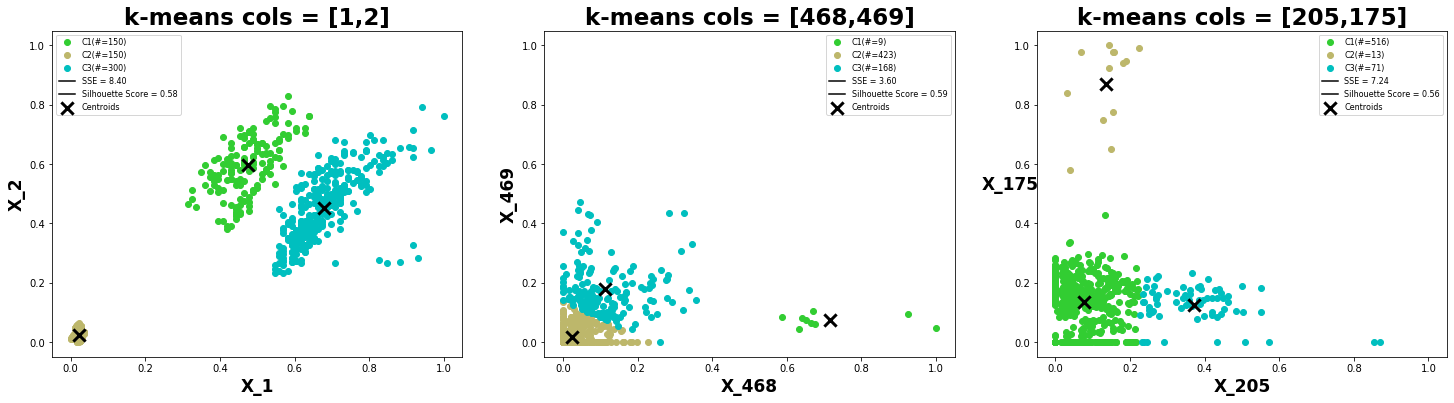

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
X_2 = xV[:, [0,1]]
X_4 = xV[:, [-2,-1]]
X_5 = xV[:, [205,175]]
k = 3



# normalizing the data with respect to the axes 
X_2 = normalize(X_2)
X_4 = normalize(X_4)
X_5 = normalize(X_5)

# Performing k-means for every dataset 
kmeans = KMeans(n_clusters=k).fit(X_2)
IDX_2 = kmeans.labels_
C_2 = kmeans.cluster_centers_

kmeans = KMeans(n_clusters=k).fit(X_4)
IDX_4 = kmeans.labels_
C_4 = kmeans.cluster_centers_

kmeans = KMeans(n_clusters=k).fit(X_5)
IDX_5 = kmeans.labels_
C_5 = kmeans.cluster_centers_

# calculating the silhouette score
sil_2 = silhouette_score(X_2, IDX_2)
sil_4 = silhouette_score(X_4, IDX_4)
sil_5 = silhouette_score(X_5, IDX_5)

# calculating the sse 
sse_2 = SSE(X_2, C_2, k)
sse_4 = SSE(X_4, C_4, k)
sse_5 = SSE(X_5, C_5, k)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(25,6))

plt.rcParams['legend.fontsize'] = 8 # changing the size of the legend 

# Putting plot from step 2 in ax1
ax1.set_xlabel('X_1', fontweight='bold', fontsize=17) # changing fontweight and size
ax1.set_ylabel('X_2', fontweight='bold', fontsize=17)
ax1.set_title('k-means cols = [1,2]', fontsize=23, fontweight='bold')
ax1.set_ylim([-0.05,1.05])
ax1.set_xlim([-0.05,1.05])

ax1.plot(X_2[IDX_2==0][:, 0], X_2[IDX_2==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1(#={})'.format(len(X_2[IDX_2==0])))
ax1.plot(X_2[IDX_2==1][:, 0], X_2[IDX_2==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2(#={})'.format(len(X_2[IDX_2==1])))
ax1.plot(X_2[IDX_2==2][:, 0], X_2[IDX_2==2][:, 1], 'c.', marker='o', linewidth=0, label='C3(#={})'.format(len(X_2[IDX_2==2])))


# adding the SSE to the plot 
ax1.plot([], [], label='SSE = {:.2f}'.format(sse_2), color='black')
ax1.plot([], [], label='Silhouette Score = {:.2f}'.format(sil_2), color='black')

ax1.scatter(C_2[:, 0], C_2[:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)

ax1.legend(loc='upper left')

# Putting plot from step 4 in ax2

ax2.set_xlabel('X_468', fontweight='bold', fontsize=17) # changing fontweight and size
ax2.set_ylabel('X_469', fontweight='bold', fontsize=17)
ax2.set_title('k-means cols = [468,469]', fontsize=23, fontweight='bold')
ax2.set_ylim([-0.05,1.05])
ax2.set_xlim([-0.05,1.05])

ax2.plot(X_4[IDX_4==0][:, 0], X_4[IDX_4==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1(#={})'.format(len(X_4[IDX_4==0])))
ax2.plot(X_4[IDX_4==1][:, 0], X_4[IDX_4==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2(#={})'.format(len(X_4[IDX_4==1])))
ax2.plot(X_4[IDX_4==2][:, 0], X_4[IDX_4==2][:, 1], 'c.', marker='o', linewidth=0, label='C3(#={})'.format(len(X_4[IDX_4==2])))


# adding the SSE to the plot 
ax2.plot([], [], label='SSE = {:.2f}'.format(sse_4), color='black')
ax2.plot([], [], label='Silhouette Score = {:.2f}'.format(sil_4), color='black')

ax2.scatter(C_4[:, 0], C_4[:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)

ax2.legend()

# Putting plot from step 4 in ax2

ax3.set_xlabel('X_205', fontweight='bold', fontsize=17) # changing fontweight and size
ax3.set_ylabel('X_175', fontweight='bold', fontsize=17, rotation=360)
ax3.set_title('k-means cols = [205,175]', fontsize=23, fontweight='bold')
ax3.set_ylim([-0.05,1.05])
ax3.set_xlim([-0.05,1.05])

ax3.plot(X_5[IDX_5==0][:, 0], X_5[IDX_5==0][:, 1], 'limegreen', marker='o', linewidth=0, label='C1(#={})'.format(len(X_5[IDX_5==0])))
ax3.plot(X_5[IDX_5==1][:, 0], X_5[IDX_5==1][:, 1], 'darkkhaki', marker='o', linewidth=0, label='C2(#={})'.format(len(X_5[IDX_5==1])))
ax3.plot(X_5[IDX_5==2][:, 0], X_5[IDX_5==2][:, 1], 'c.', marker='o', linewidth=0, label='C3(#={})'.format(len(X_5[IDX_5==2])))
ax3.scatter(C_5[:, 0], C_5[:, 1], marker='x', color='black', s=150, linewidth=3, label='Centroids', zorder=10)


# adding the SSE to the plot 
ax3.plot([], [], label='SSE = {:.2f}'.format(sse_5), color='black')
ax3.plot([], [], label='Silhouette Score = {:.2f}'.format(sil_5), color='black')

ax3.legend()

plt.savefig('Plots/kmeans_xV_all_cols.png')
plt.show()

# DBSCAN Clustering 

##  mydata.mat Dataset

In [30]:
import scipy.io
import numpy as np

mat_file = scipy.io.loadmat('mydata.mat')
X = np.array(mat_file['X'])

In [31]:
from sklearn.cluster import DBSCAN 

epsilon = 0.5
MinPts = 15

dbscan = DBSCAN(eps=epsilon, min_samples=MinPts).fit(X)
IDX = dbscan.labels_

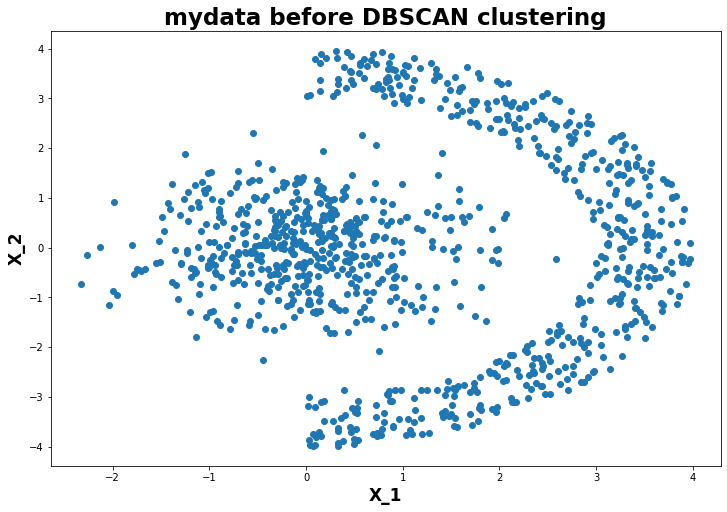

In [32]:
import matplotlib.pyplot as plt 
plt.rcParams['legend.fontsize'] = 10 # changing the size of the legend 

plt.figure(figsize=(12,8)) # changing the size of the figure 
plt.xlabel('X_1', fontsize=17, fontweight='bold')
plt.ylabel('X_2', fontsize=17, fontweight='bold')
plt.title('mydata before DBSCAN clustering', fontweight='bold', fontsize=23)

plt.scatter(X[:, 0], X[:, 1])

plt.savefig('Plots/mydata_dbscan_before.png')
plt.show() # showing the figure 

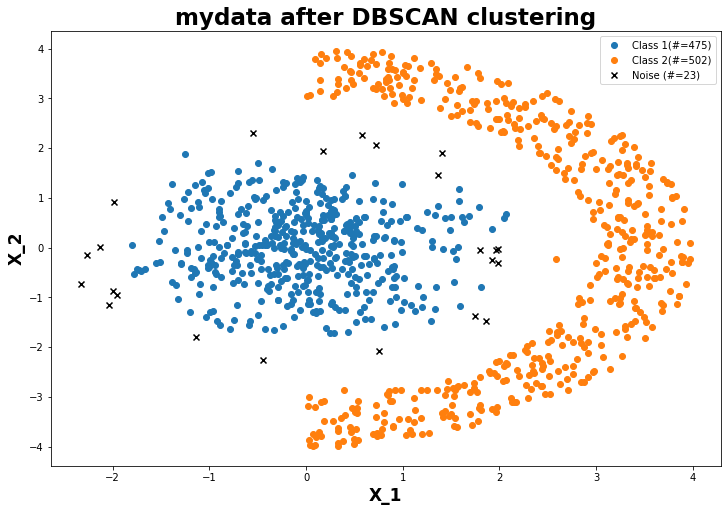

In [33]:
plt.figure(figsize=(12,8))

plt.xlabel('X_1', fontsize=17, fontweight='bold')
plt.ylabel('X_2', fontsize=17, fontweight='bold')
plt.title('mydata after DBSCAN clustering', fontweight='bold', fontsize=23)

plt.scatter(X[IDX==0][:, 0], X[IDX==0][:, 1], label='Class 1(#={})'.format(len(X[IDX==-0])))
plt.scatter(X[IDX==1][:, 0], X[IDX==1][:, 1], label='Class 2(#={})'.format(len(X[IDX==1])))
plt.scatter(X[IDX==-1][:, 0], X[IDX==-1][:, 1], c='k', marker='x', label='Noise (#={})'.format(len(X[IDX==-1])))

plt.legend()
plt.savefig('Plots/mydata_dbscan_after.png')
plt.show()

## Iris Dataset 

In [34]:
from sklearn.datasets import load_iris

meas = load_iris().data

X = meas[:, [2,3]]

In [35]:
from sklearn.cluster import DBSCAN 

epsilon = 0.2
MinPts = 5

dbscan = DBSCAN(eps=epsilon, min_samples=MinPts).fit(X)
IDX = dbscan.labels_

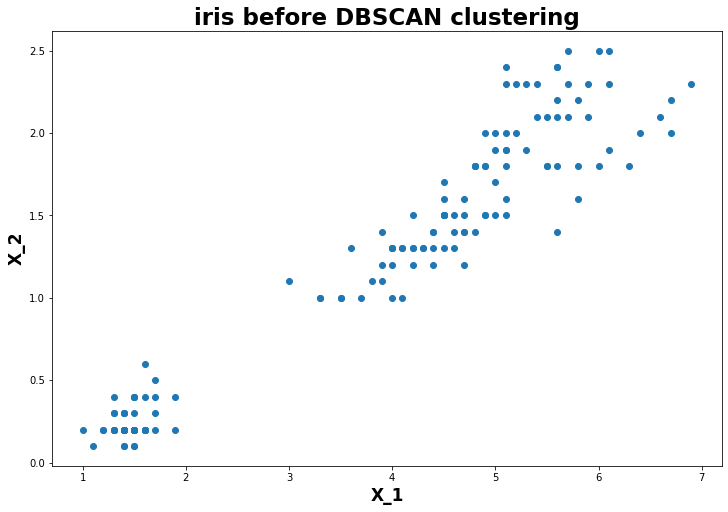

In [36]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,8))

plt.xlabel('X_1', fontsize=17, fontweight='bold')
plt.ylabel('X_2', fontsize=17, fontweight='bold')
plt.title('iris before DBSCAN clustering', fontweight='bold', fontsize=23)
plt.scatter(X[:, 0], X[:, 1])
plt.savefig('Plots/iris_dbscan_before.png')

plt.show()


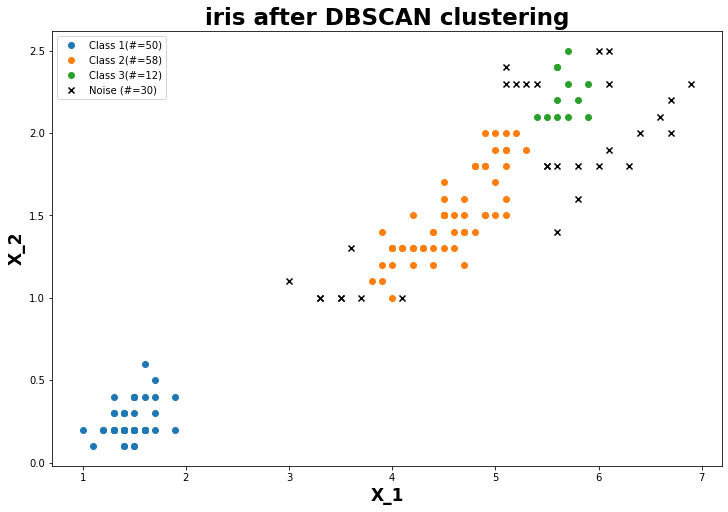

In [37]:
plt.figure(figsize=(12,8))

plt.xlabel('X_1', fontsize=17, fontweight='bold')
plt.ylabel('X_2', fontsize=17, fontweight='bold')
plt.title('iris after DBSCAN clustering', fontweight='bold', fontsize=23)


plt.scatter(X[IDX==0][:, 0], X[IDX==0][:, 1], label='Class 1(#={})'.format(len(X[IDX==0])))
plt.scatter(X[IDX==1][:, 0], X[IDX==1][:, 1], label='Class 2(#={})'.format(len(X[IDX==1])))
plt.scatter(X[IDX==2][:, 0], X[IDX==2][:, 1], label='Class 3(#={})'.format(len(X[IDX==2])))
plt.scatter(X[IDX==-1][:, 0], X[IDX==-1][:, 1], c='k', marker='x', label='Noise (#={})'.format(len(X[IDX==-1])))


plt.legend()
plt.savefig('Plots/iris_dbscan_after.png')
plt.show()

In [38]:
from scipy.stats import zscore

xV1 = zscore(X[: ,0])
xV2 = zscore(X[: ,1])

X = np.array([xV1, xV2])
X = X.reshape((150, 2))

dbscan = DBSCAN(eps=epsilon, min_samples=MinPts).fit(X)
IDX = dbscan.labels_

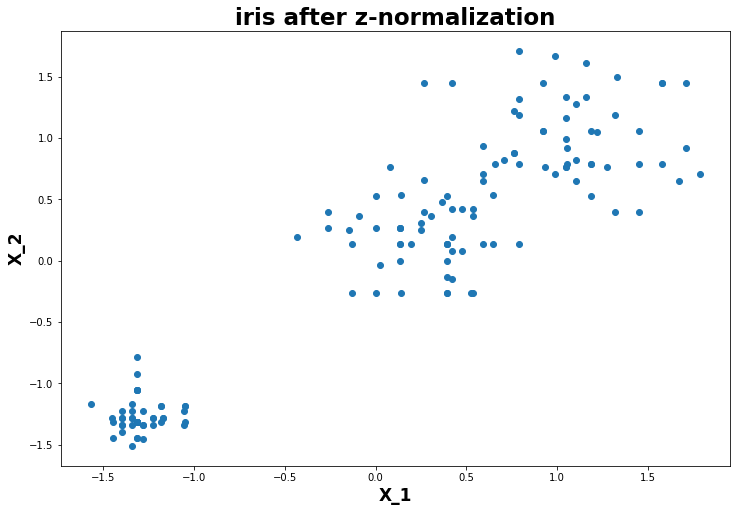

In [39]:
plt.figure(figsize=(12,8))

plt.xlabel('X_1', fontsize=17, fontweight='bold')
plt.ylabel('X_2', fontsize=17, fontweight='bold')
plt.title('iris after z-normalization', fontweight='bold', fontsize=23)

plt.scatter(X[:, 0], X[:, 1])

plt.savefig('Plots/iris_after_norm.png')

plt.show()

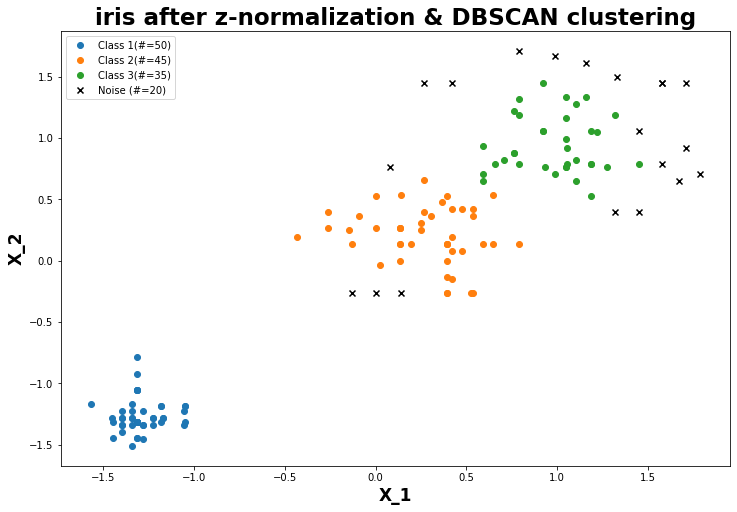

In [40]:
plt.figure(figsize=(12,8))

plt.xlabel('X_1', fontsize=17, fontweight='bold')
plt.ylabel('X_2', fontsize=17, fontweight='bold')
plt.title('iris after z-normalization & DBSCAN clustering', fontweight='bold', fontsize=23)

plt.scatter(X[IDX==0][:, 0], X[IDX==0][:, 1], label='Class 1(#={})'.format(len(X[IDX==0])))
plt.scatter(X[IDX==1][:, 0], X[IDX==1][:, 1], label='Class 2(#={})'.format(len(X[IDX==1])))
plt.scatter(X[IDX==2][:, 0], X[IDX==2][:, 1], label='Class 3(#={})'.format(len(X[IDX==2])))
plt.scatter(X[IDX==-1][:, 0], X[IDX==-1][:, 1], c='k', marker='x', label='Noise (#={})'.format(len(X[IDX==-1])))

plt.legend()
plt.savefig('Plots/iris_dbscan_after_norm.png')

plt.show()

## xV.mat Dataset

In [41]:
import scipy.io 
import numpy as np 

mat_file = scipy.io.loadmat('xV.mat')
xV = np.array(mat_file['xV'])

In [42]:
X = xV[:, [0, 1]]

from sklearn.cluster import DBSCAN

epsilon = 0.3
MinPts = 50 

dbscan = DBSCAN(eps=epsilon, min_samples=MinPts).fit(X)
IDX = dbscan.labels_

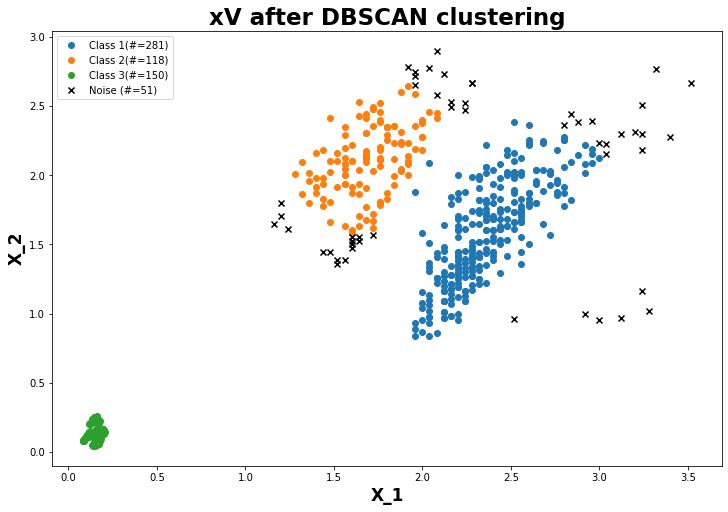

In [43]:
plt.figure(figsize=(12,8))

plt.scatter(X[IDX==0][:, 0], X[IDX==0][:, 1], label='Class 1(#={})'.format(len(X[IDX==0])))
plt.scatter(X[IDX==1][:, 0], X[IDX==1][:, 1], label='Class 2(#={})'.format(len(X[IDX==1])))
plt.scatter(X[IDX==2][:, 0], X[IDX==2][:, 1], label='Class 3(#={})'.format(len(X[IDX==2])))
plt.scatter(X[IDX==-1][:, 0], X[IDX==-1][:, 1], c='k', marker='x', label='Noise (#={})'.format(len(X[IDX==-1])))

plt.xlabel('X_1', fontsize=17, fontweight='bold')
plt.ylabel('X_2', fontsize=17, fontweight='bold')
plt.title('xV after DBSCAN clustering', fontweight='bold', fontsize=23)


plt.legend()
plt.savefig('Plots/xV_dbscan_after.png')
plt.show()

In [44]:
X = xV[:, [0, 1]]

label_list = [] # this will hold the results

MinPts_list = [i for i in range(48,53)] # the list of MinPts values
eps_list = np.linspace(0.3, 0.33, 5) # the list of epsilon values 

combos = list(itertools.product(MinPts_list, eps_list)) # their combos

for i in range(len(combos)):
  MinPts = combos[i][0]
  epsilon = combos[i][1]

  dbscan = DBSCAN(eps=epsilon, min_samples=MinPts).fit(X)
  label_list.append(dbscan.labels_)

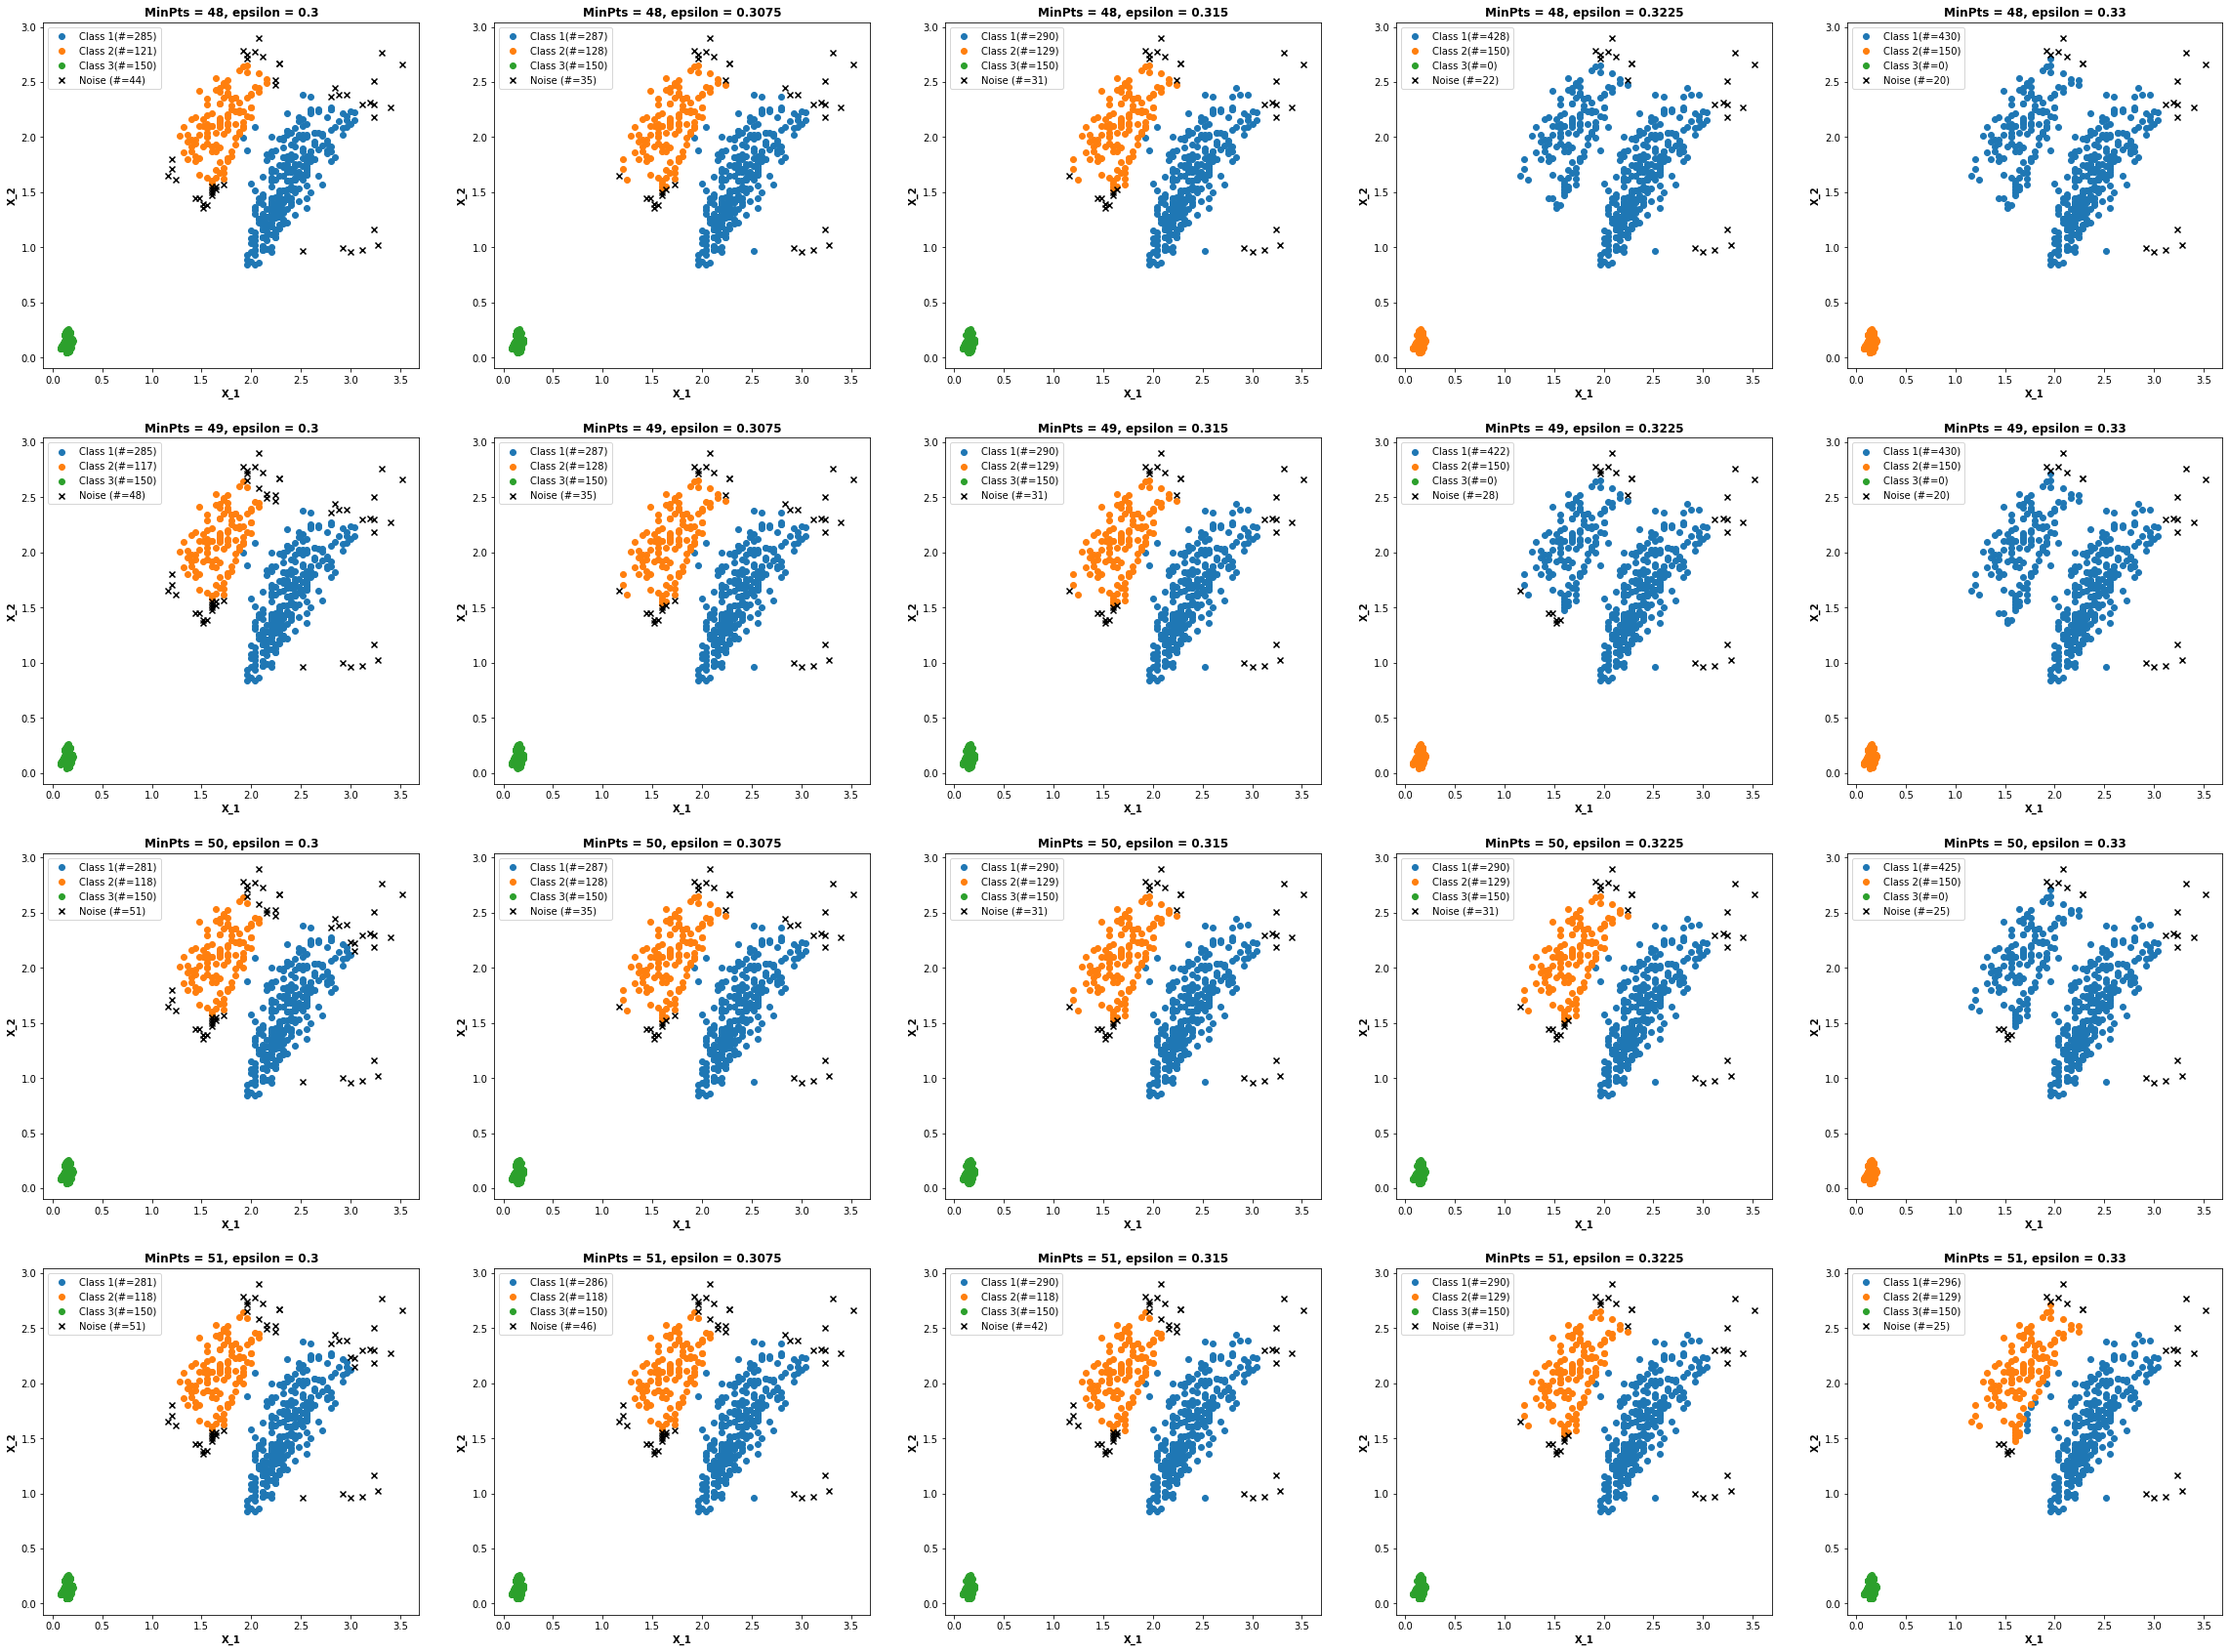

In [45]:
fig, ((ax1, ax2, ax3, ax4, ax5),
      (ax6, ax7, ax8, ax9, ax10),
      (ax11, ax12, ax13, ax14, ax15),
      (ax16, ax17, ax18, ax19, ax20)) = plt.subplots(4, 5, figsize=(40,30)) # creating 10 ax objects to draw graphs
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20]



for i in range(len(ax)):

  ax[i].scatter(X[label_list[i]==0][:, 0], X[label_list[i]==0][:, 1], label='Class 1(#={})'.format(len(X[label_list[i]==0])))
  ax[i].scatter(X[label_list[i]==1][:, 0], X[label_list[i]==1][:, 1], label='Class 2(#={})'.format(len(X[label_list[i]==1])))
  ax[i].scatter(X[label_list[i]==2][:, 0], X[label_list[i]==2][:, 1], label='Class 3(#={})'.format(len(X[label_list[i]==2])))
  ax[i].scatter(X[label_list[i]==-1][:, 0], X[label_list[i]==-1][:, 1], marker='x', c='k', label='Noise (#={})'.format(len(X[label_list[i]==-1])))

  ax[i].set_xlabel('X_1', fontsize=10, fontweight='bold') # setting the label bold and size 10
  ax[i].set_ylabel('X_2', fontsize=10, fontweight='bold') # setting the label bold, size 10 and rotating it so it is easy to read
  
  ax[i].set_title('MinPts = {}, epsilon = {}'.format(combos[i][0], combos[i][1]), fontweight='bold') # adding title 

  ax[i].legend() # adding labels

plt.savefig('Plots/xV01_dbscan_EXPS.png')
plt.show()

In [46]:
X = xV[:, [-2, -1]]

from sklearn.cluster import DBSCAN

epsilon = 0.02
MinPts = 5

dbscan = DBSCAN(eps=epsilon, min_samples=MinPts).fit(X)
IDX = dbscan.labels_

In [47]:
label_list = [] # this will hold the results

MinPts_list = [i for i in range(1,6)] # the list of MinPts values
eps_list = np.linspace(0.005, 0.01, 5) # the list of epsilon values 

combos = list(itertools.product(MinPts_list, eps_list)) # their combos

for i in range(len(combos)):
  MinPts = combos[i][0]
  epsilon = combos[i][1]

  dbscan = DBSCAN(eps=epsilon, min_samples=MinPts).fit(X)
  label_list.append(dbscan.labels_)

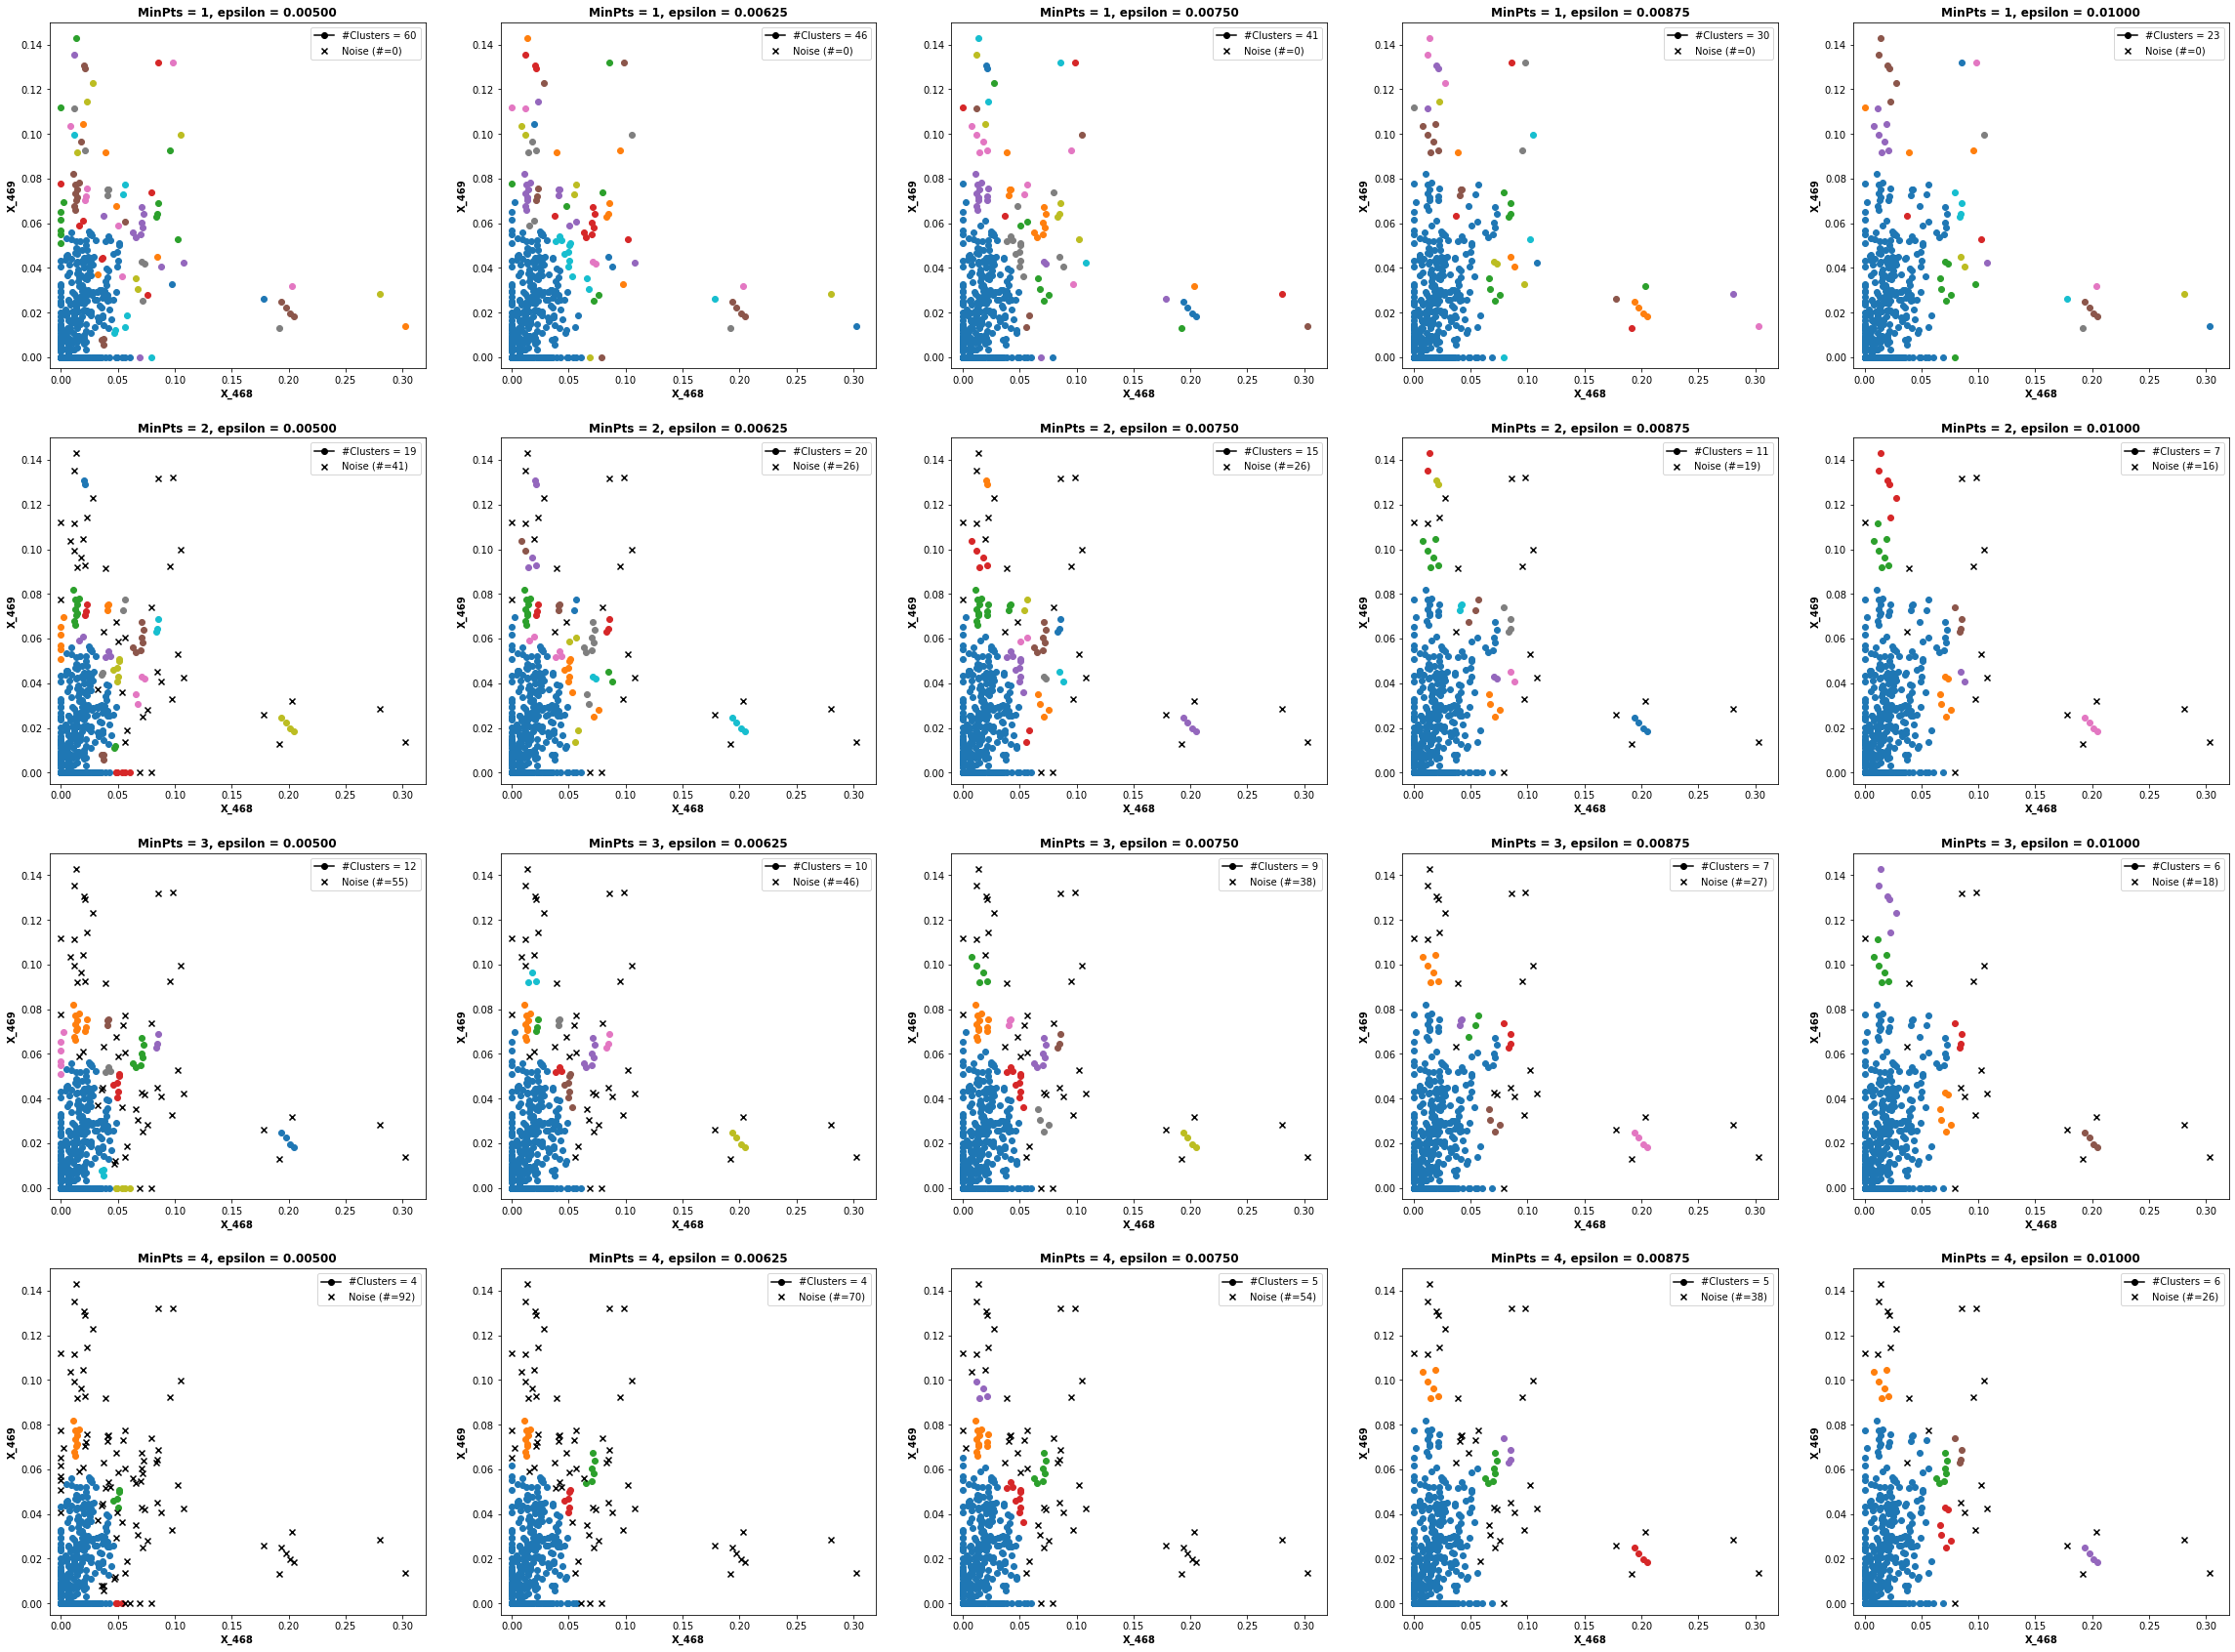

In [48]:
fig, ((ax1, ax2, ax3, ax4, ax5),
      (ax6, ax7, ax8, ax9, ax10),
      (ax11, ax12, ax13, ax14, ax15),
      (ax16, ax17, ax18, ax19, ax20)) = plt.subplots(4, 5, figsize=(40,30)) # creating 10 ax objects to draw graphs
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20]



for i in range(len(ax)):
  labels = label_list[i]
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # finding the number of labels

  for k in range(n_clusters):
    class_member = (labels == k)
    ax[i].scatter(X[class_member][:, 0], X[class_member][:, 1]) # plotting the points that are in a class
  noise = (labels == -1)
  ax[i].scatter(X[noise][:, 0], X[noise][:, 1], c='k', marker='x', label='Noise (#={})'.format(len(X[noise]))) # plotting the noise
  ax[i].plot([],[], marker="o", c='k', label='#Clusters = {}'.format(n_clusters))
  ax[i].set_xlabel('X_468', fontsize=10, fontweight='bold') # setting the label bold and size 10
  ax[i].set_ylabel('X_469', fontsize=10, fontweight='bold') # setting the label bold, size 10 and rotating it so it is easy to read
  
  ax[i].set_title('MinPts = {}, epsilon = {:.5f}'.format(combos[i][0], combos[i][1]), fontweight='bold') # adding title 
  ax[i].set_ylim([-0.005,0.15])
  ax[i].set_xlim([-0.01,0.32])
  ax[i].legend() # adding labels

plt.savefig('Plots/xV468469_dbscan_EXPS.png')
plt.show()

In [49]:
!zip -r /content/file.zip /content
from google.colab import files
files.download("/content/file.zip")


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_update_check.json (deflated 24%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.01.20/ (stored 0%)
  adding: content/.config/logs/2023.01.20/14.34.30.476454.log (deflated 54%)
  adding: content/.config/logs/2023.01.20/14.34.57.156862.log (deflated 54%)
  adding: content/.config/logs/2023.01.20/14.34.56.325690.log (deflated 54%)
  adding: content/.config/logs/2023.01.20/14.33.57.412394.log (deflated 53%)
  adding: content/.config/logs/2023.01.20/14.34.22.572544.l

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>